<a href="https://colab.research.google.com/github/TaliNatan/DSPS_TNatan/blob/main/HW10_TNatan/PINN_Burgers_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## The below code was done w/ reference to Dr. Bianco's 12/4 class recording.
## https://udel.instructure.com/courses/1735534/external_tools/151642

In [ ]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.14.0'

In [ ]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [ ]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-12-11 04:49:31--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-12-11 04:49:31--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.03s   

2023-12-11 04:49:32 (7.62 MB/s) - ‘burgers_shock.mat’ saved

(100,) (256,) (256, 100)


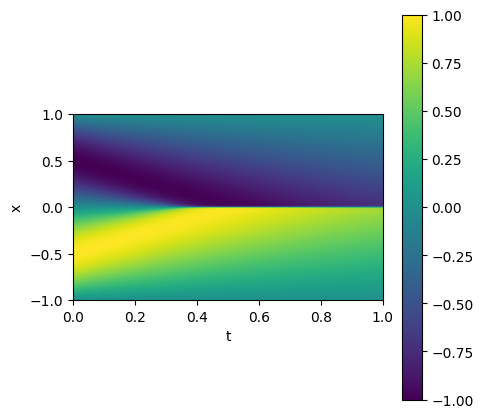

In [ ]:
### what is the solution that we want? read in the data

## In this assignment, we are looking to used physically informed neural
## networks to solve Burger's equations. To start, we are taking in real results
## of the equations that we can use both to train the network but also to later
## check our results.

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation. At small time, location of high and low
## speeds are far from each other and the difference bewteen them is smooth.
## Over time, though, a shock is formed between regions of high and low speed.

# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [ ]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [ ]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [ ]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [ ]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0;

# evaluate initial condition at x_0

In [ ]:
u_0 = fun_u_0(x_0) #eq 2
u_0;

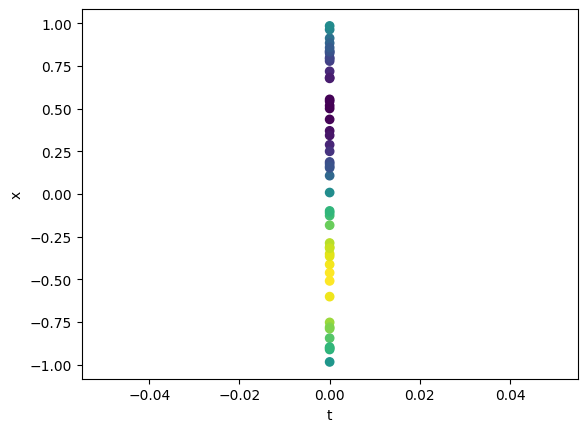

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation at time = 0. This position space has
## been randomly sampled for the neural network to later learn from.

# get data at boundaries of x at random t's



In [ ]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b;

# evaluate data at boundaries of x at random t's


In [ ]:
u_b = fun_u_b(t_b, x_b)
u_b;

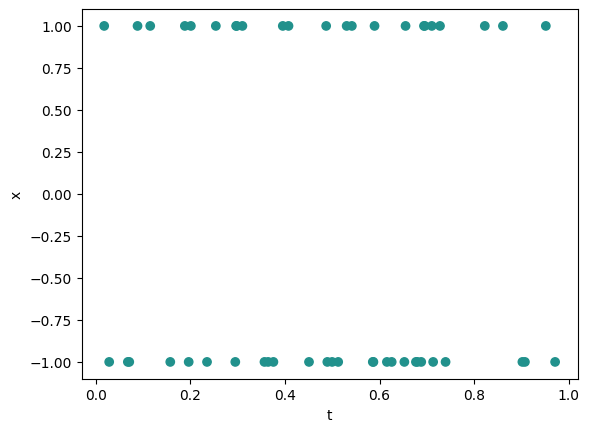

In [ ]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation along the physical boundaries. We are
## setting the boundary to be a constant at all times.

# get points inside the space at random where the function will be predicted

In [ ]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r;

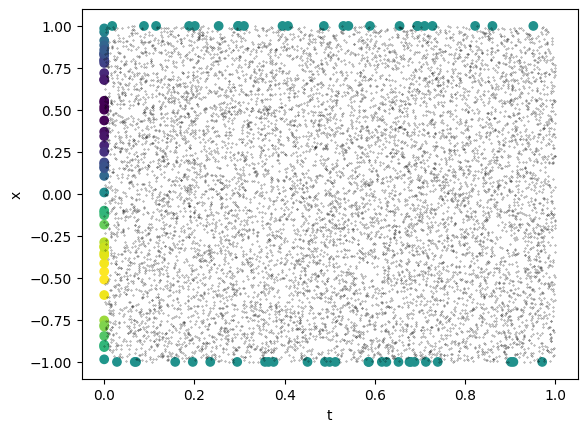

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation along the physical boundaries and at
## time 0. The grey scattered points are the times/locations the neural network
## will predict over.

In [ ]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

# create the model with simple loss

In [ ]:
## From Dr. Bianco

nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.Input(2))

#8 hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation = 'tanh'))
  ## looping over sequential layers instead of stacking them and haveing line
  ## i+1 take in the model of line i

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(1))

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(u_pred, u_data):
  '''
  u_pred :: 1D array, predicted velocity values
  u_data :: 1D array, actual velocity values from original .mat file
  '''
  return tf.reduce_mean(tf.square(u_data - u_pred)) # using the L2 value for loss

In [ ]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [ ]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 7s 9ms/step - loss: 0.1991
Epoch 2/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1848
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1865
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1825
Epoch 5/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1767
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1735
Epoch 7/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1705
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1640
Epoch 9/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1563
Epoch 10/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1485
Epoch 11/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1411
Epoch 12/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1312
Epoch 13/1000
4/4 [==============================

Text(0, 0.5, 'loss')

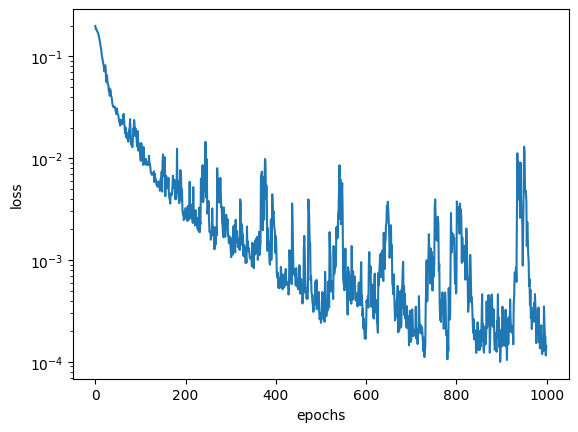

In [ ]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

In [ ]:
## The above plot shows loss as a function of epochs of neural network learning.
## Overall, the loss goes down over all 1000 epochs but it is very noisy
## indicating that the learning rate may be too high.

## see the result

In [ ]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 2ms/step


array([[-0.0078331 ],
       [-0.02858678],
       [ 0.11578712],
       ...,
       [-0.02077046],
       [ 0.0209085 ],
       [-0.00570664]], dtype=float32)

313/313 [==============================] - 1s 2ms/step


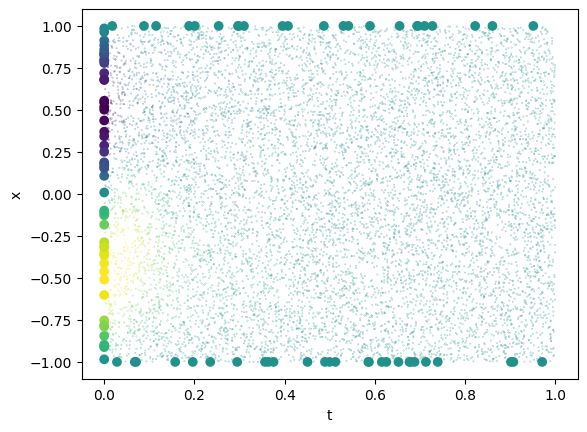

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation along the physical boundaries and at
## time 0. The smaller scattered points are the times/locations the neural
## network predicted. As you can see, the speed very quickly fades to 0 at times
## later than 0. Considering the boundary conditions, this is a reasonable
## guess, albiet non-physical (doesn't follow Burger's Eqs).

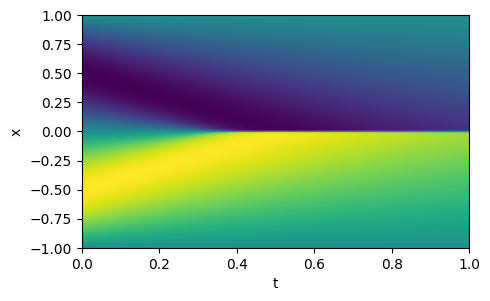

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation. At small time, location of high and low
## speeds are far from each other and the difference bewteen them is smooth.
## Over time, though, a shock is formed between regions of high and low speed.
## I think this plot is to serve as a reminder for the actual result we want.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


6.938189004668799

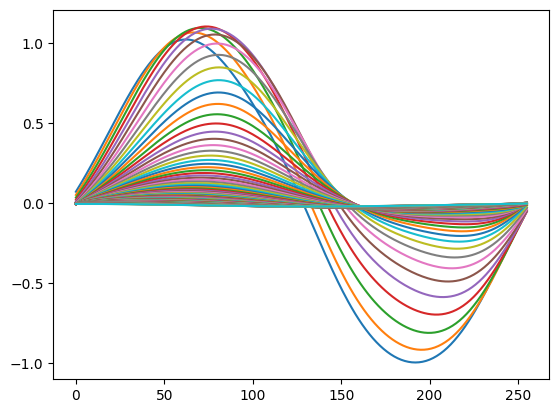

In [ ]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

In [ ]:
## The above plot shows L1 accuracy of every point. There is a sinusoidal
## behavior to this plot - when there is massive error it is both wrong in the
## + and - but this decays to zero.

8/8 [==============================] - 0s 3ms/step


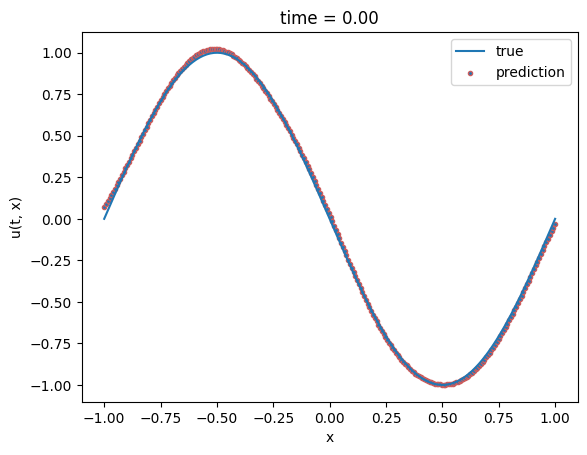

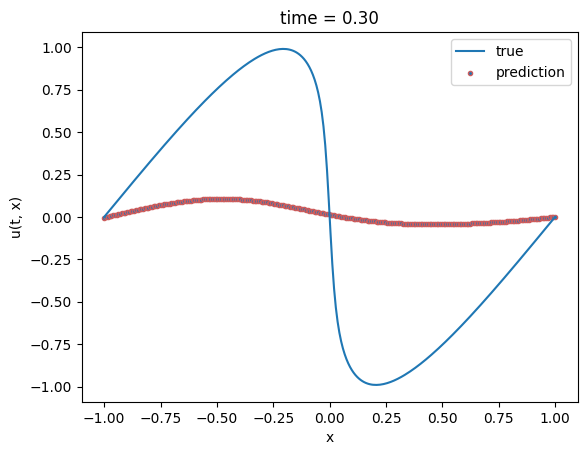

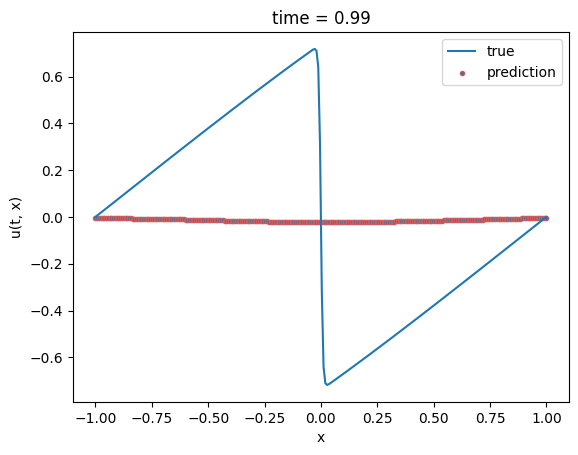

In [ ]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


In [ ]:
## The above plots shows the prue versus predicted particle velocity at
## different times. At t = 0, the predicted values are right on top of the true
## values but quickly after, the results diverge - the neural network does a
## bad job of capturing the data at later times without a physically motivated
## loss function.

# create the model with complete loss

In [ ]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


In [ ]:
## From Dr. Bianco's video
def custom_loss(model, X_r, X, y):
    u_pred = model(X)
    loss = tf.reduce_mean(tf.square(y-u_pred))
    u_pred, u_t, u_x, u_xx = get_pde(model, X_r)
    resids = fun_res(u_pred, u_t, u_x, u_xx)
    loss += tf.reduce_mean(tf.square(resids))
    return loss

In [ ]:
## From Dr. Bianco's video
def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent = True) as tape:
      tape.watch(model.trainable_variables)
      loss = custom_loss(model, X_r, X, y)
    g = tape.gradient(loss, model.trainable_variables)
    del TV_Reshape_Tshape

    return loss, g

## train the model

In [ ]:
import copy

In [ ]:
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.Input(2))
#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(20, activation = 'tanh'))
#output layer is 1D
pinn.add(tf.keras.layers.Dense(1))

In [ ]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))



It 00000: loss = 4.80015218e-01
It 00050: loss = 1.01452008e-01
It 00100: loss = 7.48850405e-02
It 00150: loss = 6.07726350e-02
It 00200: loss = 5.28077595e-02
It 00250: loss = 4.88752872e-02
It 00300: loss = 5.62812835e-02
It 00350: loss = 3.86179797e-02
It 00400: loss = 5.18918708e-02
It 00450: loss = 3.79107594e-02
It 00500: loss = 2.60262787e-02
It 00550: loss = 3.80133688e-02
It 00600: loss = 1.36725716e-02
It 00650: loss = 1.59467887e-02
It 00700: loss = 4.06797230e-02
It 00750: loss = 8.80889036e-03
It 00800: loss = 1.83036048e-02
It 00850: loss = 1.04797035e-02
It 00900: loss = 4.70526610e-03
It 00950: loss = 1.83106452e-01
It 01000: loss = 8.15614685e-02
It 01050: loss = 6.05949946e-02
It 01100: loss = 5.16722500e-02
It 01150: loss = 4.57633398e-02
It 01200: loss = 4.01955061e-02
It 01250: loss = 3.42086665e-02
It 01300: loss = 3.43697779e-02
It 01350: loss = 2.42079832e-02
It 01400: loss = 2.29118466e-02
It 01450: loss = 3.36129248e-01
It 01500: loss = 4.30173054e-02
It 01550

313/313 [==============================] - 1s 2ms/step


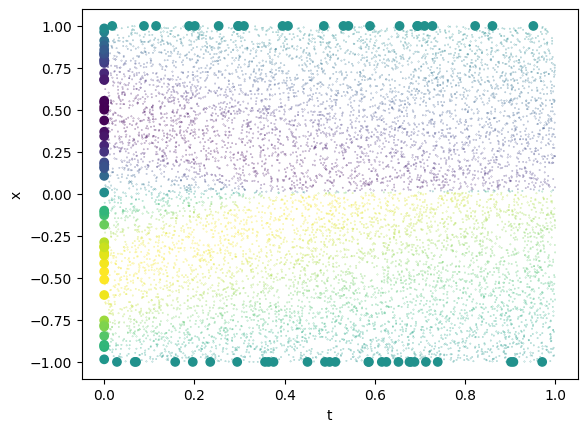

In [ ]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation along the physical boundaries and at
## time 0. The smaller scattered points are the times/locations the neural
## network predicted. As you can see, the perdicted speed does a good job of
## following Burger's Eqs at later times and looks like the actual answer now!

313/313 [==============================] - 1s 2ms/step


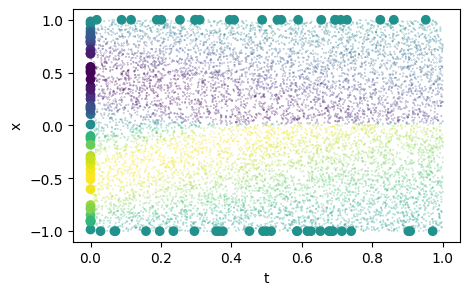

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation along the physical boundaries and at
## time 0. The smaller scattered points are the times/locations the neural
## network predicted. As you can see, the perdicted speed does a good job of
## following Burger's Eqs at later times and looks like the actual answer now!

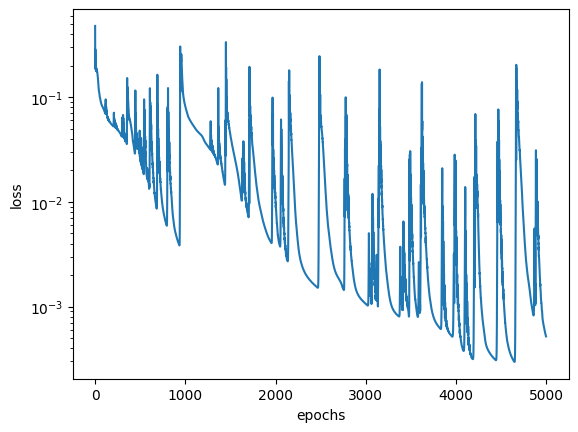

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

In [ ]:
## The above plot shows loss as a function of epochs of neural network learning.
## Overall, the loss goes down over all 5000 epochs but it is very noisy
## indicating that the learning rate may be too high.

8/8 [==============================] - 0s 2ms/step


3.480264345034789

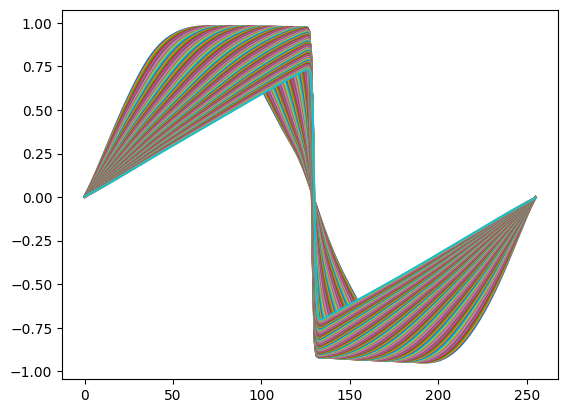

In [ ]:
L1accuracy(t, x, pinn)

In [ ]:
## The above plot shows L1 accuracy of every point. There is a sinusoidal
## behavior to this plot - when there is massive error it is both wrong in the
## + and - but this does not decay to zero like the previous version of this
## plot.

# adjust the learning rate and trin some more
the loss was awfully noisy

In [ ]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 5.15103748e-04
It 00050: loss = 5.10592712e-04
It 00100: loss = 5.06523531e-04
It 00150: loss = 5.02447365e-04
It 00200: loss = 4.98273759e-04
It 00250: loss = 4.93931351e-04
It 00300: loss = 4.89329221e-04
It 00350: loss = 4.84325865e-04
It 00400: loss = 4.78667498e-04
It 00450: loss = 4.71925945e-04
It 00500: loss = 4.63404780e-04
It 00550: loss = 4.52286185e-04
It 00600: loss = 4.39225638e-04
It 00650: loss = 4.27579973e-04
It 00700: loss = 4.18918149e-04
It 00750: loss = 4.11974877e-04
It 00800: loss = 4.05855360e-04
It 00850: loss = 4.00260207e-04
It 00900: loss = 3.95108655e-04
It 00950: loss = 3.90363915e-04
It 01000: loss = 3.85985826e-04
It 01050: loss = 3.81939870e-04
It 01100: loss = 3.78180004e-04
It 01150: loss = 3.74654541e-04
It 01200: loss = 3.71313363e-04
It 01250: loss = 3.68111505e-04
It 01300: loss = 3.65019485e-04
It 01350: loss = 3.62016493e-04
It 01400: loss = 3.59080062e-04
It 01450: loss = 3.56197328e-04
It 01500: loss = 3.53359239e-04
It 01550

Text(0, 0.5, 'loss')

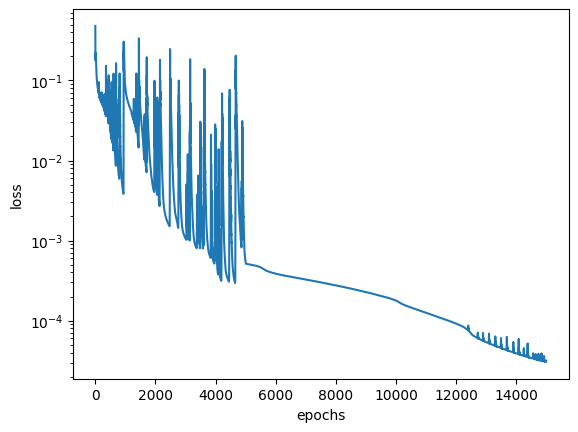

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

In [ ]:
## The above plot shows loss as a function of epochs of neural network learning.
## Overall, the loss goes down over 15000 epochs. Out to 5000 epochs, the loss
## is very noisy indicating that the learning rate was be too high but after
## dropping the learning rate to 0.0001 (from 0.001), this smoothes and drop
## nicely until 12000 epochs when there is some noise again. If we wanted to
## continue refing, this would be a good place to decrease the learning rate
## again.

313/313 [==============================] - 1s 2ms/step


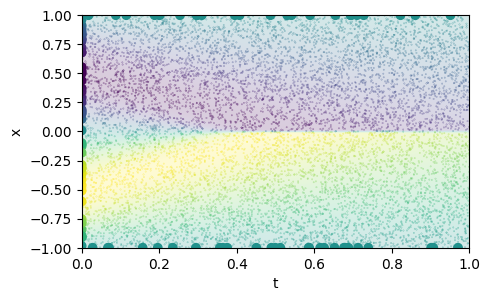

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation along the physical boundaries and at
## time 0. The smaller scattered points are the times/locations the neural
## network predicted. As you can see, the perdicted speed does a good job of
## following Burger's Eqs at later times and looks like the actual answer now!
## The transparent points (which cover nearly the entire surface) show the most
## refined neural network's prediction.

In [ ]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 3.20380786e-05
It 00050: loss = 3.00366664e-05
It 00100: loss = 3.06744259e-05
It 00150: loss = 2.95315585e-05
It 00200: loss = 2.91099641e-05
It 00250: loss = 2.89072304e-05
It 00300: loss = 2.85059305e-05
It 00350: loss = 2.83262234e-05
It 00400: loss = 2.79321466e-05
It 00450: loss = 2.76565443e-05
It 00500: loss = 2.80208078e-05
It 00550: loss = 2.71144490e-05
It 00600: loss = 2.71472200e-05
It 00650: loss = 2.66126863e-05
It 00700: loss = 2.68484364e-05
It 00750: loss = 2.61313489e-05
It 00800: loss = 2.58861910e-05
It 00850: loss = 2.77110430e-05
It 00900: loss = 2.54257538e-05
It 00950: loss = 2.55297564e-05
It 01000: loss = 2.50190296e-05
It 01050: loss = 2.60197485e-05
It 01100: loss = 2.45647116e-05
It 01150: loss = 2.52896116e-05
It 01200: loss = 2.41712733e-05
It 01250: loss = 2.41013422e-05
It 01300: loss = 2.38041102e-05
It 01350: loss = 2.35583520e-05
It 01400: loss = 2.33459414e-05
It 01450: loss = 2.31546583e-05
It 01500: loss = 2.31365993e-05
It 01550

Text(0, 0.5, 'loss')

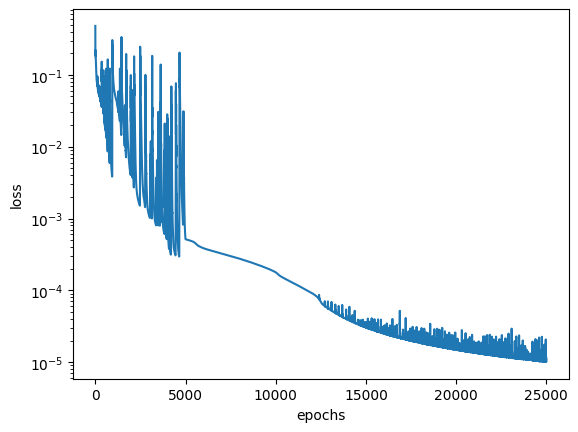

In [ ]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

In [ ]:
## The above plot shows loss as a function of epochs of neural network learning.
## Overall, the loss goes down over 25000 epochs. Out to 5000 epochs, the loss
## is very noisy indicating that the learning rate was be too high but after
## dropping the learning rate to 0.0001 (from 0.001), this smoothes and drop
## nicely until 12000 epochs when there is some noise again. This rate was
## continued further out to 25000 epochs with increasing noise (but no where as
## bad as in the first 5000 epochs).

## final result

8/8 [==============================] - 0s 2ms/step


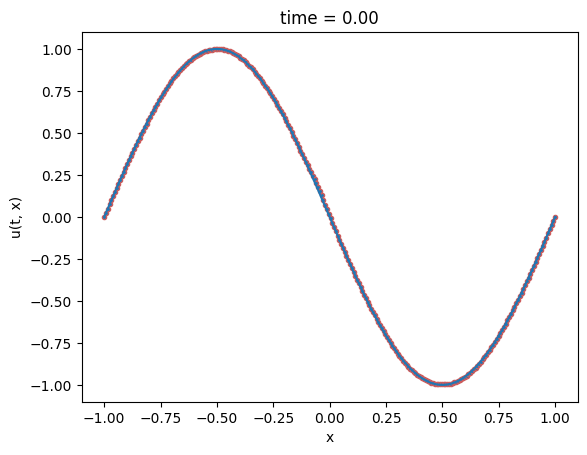

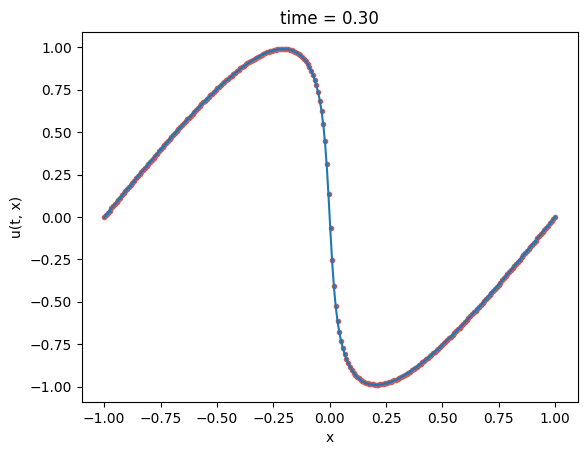

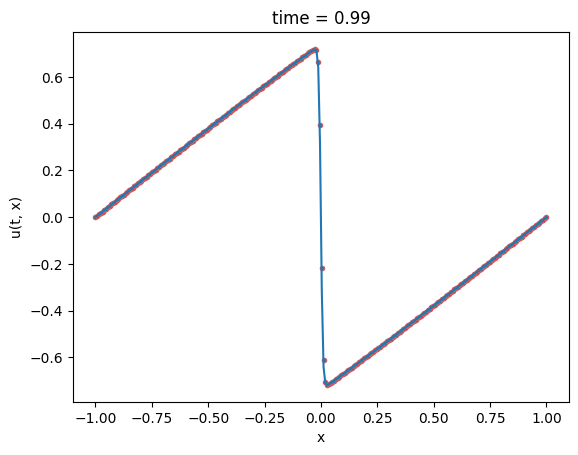

In [ ]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

In [ ]:
## The above plots shows the true versus predicted particle velocity at
## different times. At times shown, the predicted values are right on top of the
## true values. The neural network does a good job of capturing the data at all
## times with a physically motivated loss function.

313/313 [==============================] - 1s 2ms/step


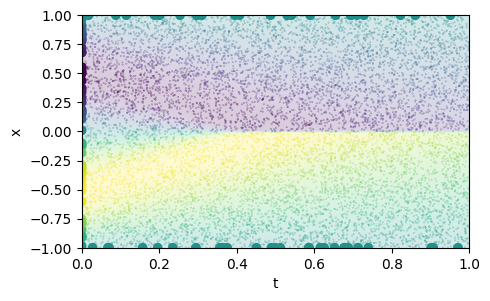

In [ ]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

In [ ]:
## The above plot shows the position versus time colored by the speed of the
## fluid as solved by Burger's equation along the physical boundaries and at
## time 0. The smaller scattered points are the times/locations the neural
## network predicted. As you can see, the perdicted speed does a good job of
## following Burger's Eqs at later times and looks like the actual answer now!
## The transparent points (which cover nearly the entire surface) show the most
## refined neural network's prediction.

8/8 [==============================] - 0s 3ms/step


0.2710964260248679

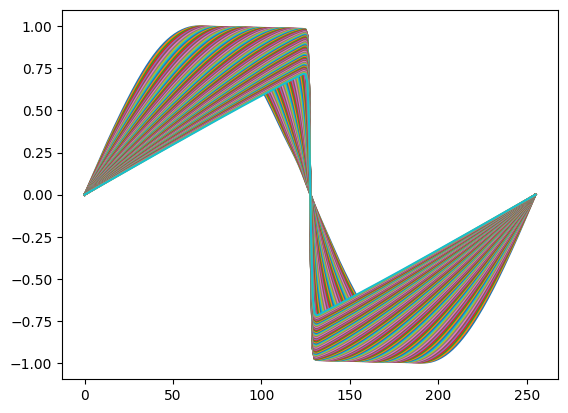

In [ ]:
L1accuracy(t, x, pinn)

In [ ]:
## The above plot shows L1 accuracy of every point. There is a sinusoidal
## behavior to this plot - when there is massive error it is both wrong in the
## + and - but this does not decay to zero like the first version of this plot.